In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# torch.manual_seed(1337)

import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from models import GPTLanguageModel, SymGPTLanguageModel, FeedForwardSeqModel, SymLMEncoder
from utils import get_batch_, estimate_loss_, calculate_cooc
import string

from sklearn.cluster import KMeans
from random import sample

In [5]:
# training hyperparameters
batch_size = 64
max_iters = 2000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.2

# model configuration
block_size = n_head = 6
n_embd = 128
n_layer = 1

# encoding config
lowercase_only = True
intermediate_vocab_size_f = [1.5]  # out_vocab_size = int(f*in_vocab_size)
                                        # f=1.0 for output vocabulary be equal to the input vocabulary size
f_seed = 1.0                            # fraction of tokens to be used for retokenization clustering   
self_loops = True              

In [6]:
outdir = './res/res_encoding_decoding_context_win_{}_vocab_f_{}_cluster_f_{}_{}_self_loops'.format(n_head, 
                                                                                    '-'.join([str(f) for f in intermediate_vocab_size_f]), 
                                                                                    f_seed,
                                                                                    'w' if self_loops else 'wo')
os.makedirs(outdir, exist_ok=True)

In [7]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('./data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
if lowercase_only:
    text = text.lower()
chars_in_text = sorted(list(set(text)))

### Notes: 
1. The pipeline now uses the character encoding as indexing! This means that we should ALWAYS start the character encoding with 0, [0, vocab_out_size-1]
2. Each re-write ignores the first block of tokens because token re-writes are performed using the context of the previous tokens in the block, mean the first block has no context. As a result, the current behavior is that each re-write "forgets" the first tokens.

In [8]:
# create a mapping from all printable characters to integers
chars = [chr(i) for i in range(128)]    # all ascii characters
chars = [i for i in string.printable]   # printable characters
chars = chars_in_text + [i for i in string.printable if i not in chars_in_text]   # the initial characters should be indexed first
target_vocab_size = len(chars_in_text)
max_vocab_size = len(chars)
print("Max vocabulary size: ", max_vocab_size)
print("Complete vocabulary: ", chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

Max vocabulary size:  100
Complete vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '"', '#', '%', '(', ')', '*', '+', '/', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\t', '\r', '\x0b', '\x0c']


### Encoding phase

In [9]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print("Chorpus size: {}".format(len(train_data)))

Chorpus size: 1003854


In [10]:
# for each encoding layer, 
# 1. calculate the cooc statistics from the prev corpus
# 2. define the symbolic attention
# 3. re-write the corpus into context-aware symbols
vocab_in = list(set(data.tolist()))
vocab_size_initial = len(vocab_in)
print("Input vocabulary size: {}".format(len(vocab_in)))
data_in = train_data.to(device)
data_val_in = val_data.to(device)
# for f in intermediate_vocab_size_f:
for it,f in enumerate(intermediate_vocab_size_f):
    ## Preprocessing
    # Co-occurence matrix calculation
    if it>0: # skip the initial statistic, only calculate and save the intermediate ones
        cooc = calculate_cooc(data_in, len(vocab_in), n_head, device=device)
        for h in range(n_head):
            plt.imshow(cooc[:,:,h].cpu().numpy())
            plt.savefig('{}/{}-cooc_{}.png'.format(outdir, h+1, f))
    elif os.path.exists('./data/cooc_{}.pth'.format(n_head)):
        cooc = torch.load('./data/cooc_{}.pth'.format(n_head)).to(device)
    else:
        cooc = calculate_cooc(data_in, len(vocab_in), n_head, device=device)
        torch.save(cooc.cpu(), './data/cooc_{}.pth'.format(n_head))
    ## Encode corpus
    # define the symbolic encoder
    vocab_out_size = min(int(f*vocab_size_initial), max_vocab_size)
    symbolic_encoder = SymLMEncoder(vocab_out_size, device, cooc, self_loops=self_loops)
    # context-aware representation
    data_enc_rep, _ = symbolic_encoder(torch.stack([data_in[i:i+block_size] for i in range(len(data_in) - block_size)]))
    data_val_enc_rep, _ = symbolic_encoder(torch.stack([data_val_in[i:i+block_size] for i in range(len(data_val_in) - block_size)]))
    print("Intermediate representation size {}: {}".format(it+1, data_enc_rep.shape[1]))
    # clustering
    data_enc_rep = data_enc_rep.numpy()
    data_val_enc_rep = data_val_enc_rep.numpy()
    n_seed = min(int(f_seed*len(data_enc_rep)), len(data_enc_rep))
    seed_idx = sample(list(range(len(data_enc_rep))), n_seed)
    data_enc_rep_seed = data_enc_rep[seed_idx]
    # encoding
    kmeans = KMeans(n_clusters=vocab_out_size).fit(data_enc_rep_seed)
    data_enc = kmeans.predict(data_enc_rep)
    data_val_enc = kmeans.predict(data_val_enc_rep)
    print("Intermediate vocabulary size {}: {}".format(it+1, vocab_out_size))
    ## Reset
    vocab_in = list(range(vocab_out_size))
    data_in = torch.tensor(data_enc, dtype=torch.long).to(device)
    data_val_in = torch.tensor(data_val_enc, dtype=torch.long).to(device)

vocab_size = len(vocab_in)
train_data_enc = data_in
val_data_enc = data_val_in
offset = block_size*len(intermediate_vocab_size_f)

Input vocabulary size: 39


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

In [ ]:
data_dict = {'train': (train_data_enc, train_data[offset:]), 'val': (val_data_enc, val_data[offset:])}
assert len(train_data_enc)==len(train_data[offset:])
assert len(val_data_enc)==len(val_data[offset:])


text_encoded = decode(train_data_enc.tolist())
with open('{}/latent_input.txt'.format(outdir), 'w') as f:
    f.write(''.join(text_encoded))

###  Re-write Analysis

In [ ]:
# # preprocessing: Co-occurence matrix calculation
# cooc = calculate_cooc(data_dict['train'][0], vocab_size, n_head, device=device) 
# # save the cooc statistics
# for h in range(n_head):
#     plt.imshow(cooc[:,:,h].cpu().numpy())
#     plt.savefig('{}/{}-cooc_{}.png'.format(outdir, h+1, intermediate_vocab_size_f[-1]))

### Decoding phase

#### Training

In [ ]:
model_types = ['symbolic'] #, 'original', 'baseline']

From SymbolicMultiHeadAttention: N 58, K 6, hs 348, embedding_dim 128
======>
Model type:  symbolic
0.525751 M parameters
Model:  SymGPTLanguageModel(
  (blocks): Sequential(
    (0): SymbolicBlock(
      (sa): SymbolicMultiHeadAttention(
        (heads): ModuleList(
          (0): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
          (1): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
          (2): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
          (3): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
          (4): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
          (5): SymbolicAttentionHead(
            (value): Embedding(58, 348)
          )
        )
        (proj): Linear(in_features=2088, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
  

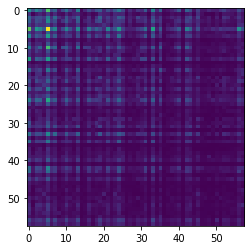

In [ ]:
for model_type in model_types:
    if model_type=='symbolic':
        # preprocessing: Co-occurence matrix calculation
        cooc = calculate_cooc(data_dict['train'][0], vocab_size, n_head, device=device) 
        # save the cooc statistics
        torch.save(cooc.cpu(), '{}/cooc_{}.pth'.format(outdir, intermediate_vocab_size_f[-1]))
        for h in range(n_head):
            plt.imshow(cooc[:,:,h].cpu().numpy())
            plt.savefig('{}/{}-cooc_{}.png'.format(outdir, h+1, intermediate_vocab_size_f[-1]))
        model = SymGPTLanguageModel(target_vocab_size, n_embd, n_head, n_layer, block_size, dropout, device, cooc)  
    elif model_type=='original':
        model = GPTLanguageModel(target_vocab_size, n_embd, n_head, n_layer, block_size, dropout, device)
    elif model_type=='baseline':
        model = FeedForwardSeqModel(target_vocab_size, n_embd, n_head, n_layer, block_size, dropout, device)
    else:
        assert False, "Undefined model type."
    model = model.to(device)
    print('======>\nModel type: ', model_type)
    # print the number of parameters in the model
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
    # print model summary
    print('Model: ', model)

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # bookkeeping
    losses_log = dict({'iter': [], 'train': [], 'val': []})

    for iter in range(max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss_(model, data_dict, eval_iters, block_size, batch_size, device=device)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            losses_log['train'].append(losses['train'].item())
            losses_log['val'].append(losses['val'].item())
            losses_log['iter'].append(iter)

        # sample a batch of data
        xb, yb = get_batch_(data_dict, 'train', block_size, batch_size, device)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # save losses
    with open('{}/losses_{}.json'.format(outdir, model_type), 'w') as fp:
        json.dump(losses_log, fp)

    # save model
    torch.save(model.state_dict(), '{}/gpt_{}.pth'.format(outdir, model_type))